<a href="https://colab.research.google.com/github/tjdgml1077/Heart-Attack-Analysis/blob/main/Heart_Attack_Analysis_%EC%A0%95%EB%A6%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%cd "/content/drive/MyDrive/kaggle/Heart Attack Analysis"

/content/drive/MyDrive/kaggle/Heart Attack Analysis


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objs as go
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # for K-fold cross validation
from sklearn.model_selection import cross_val_score # score evaluation
from sklearn.model_selection import cross_val_predict # prediction
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xg

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,roc_auc_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer

In [26]:
heart_df = pd.read_csv("heart.csv")
heart_df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
# 각 컬럼의 고유한 클래스 개수
dict = {}
for i in list(heart_df.columns):
    dict[i] = heart_df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
age,41
sex,2
cp,4
trtbps,49
chol,152
fbs,2
restecg,3
thalachh,91
exng,2
oldpeak,40


In [6]:
heart_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.366337,9.082101,29.0,47.5,55.0,61.0,77.0
sex,303.0,0.683168,0.466011,0.0,0.0,1.0,1.0,1.0
cp,303.0,0.966997,1.032052,0.0,0.0,1.0,2.0,3.0
trtbps,303.0,131.623762,17.538143,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.264026,51.830751,126.0,211.0,240.0,274.5,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.528053,0.525860,0.0,0.0,1.0,1.0,2.0
thalachh,303.0,149.646865,22.905161,71.0,133.5,153.0,166.0,202.0
exng,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


# Target label 확인

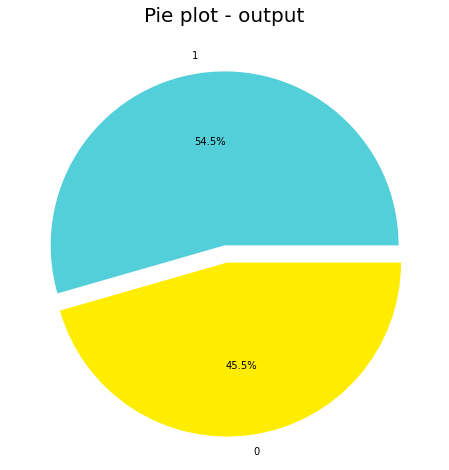

In [13]:
plt.figure(figsize = (8, 8))
heart_df['output'].value_counts().plot.pie(explode = [0, 0.1], autopct = "%1.1f%%", colors = ['#53CFDA', '#FFED00']) # colors = ['#53CFDA', '#FFED00']
plt.title("Pie plot - output", fontsize = 20)
plt.ylabel("")
plt.show()

output 분포가 어느 정도 balanced 하다.

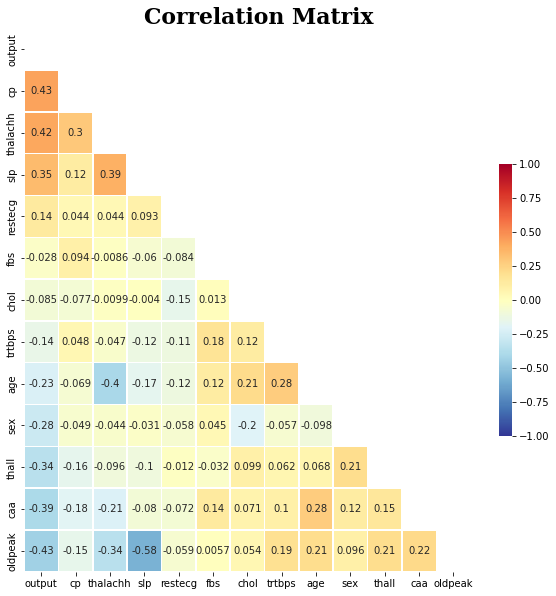

In [29]:
cor = heart_df.corr()
fig, ax = plt.subplots( figsize=(10,10) )

k = 13 #number of variables for heatmap
cols = cor.nlargest(k, 'output')['output'].index
cm = np.corrcoef(heart_df[cols].values.T)

mask = np.zeros_like(cm, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(cm, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1, vmax = 1, # 컬러바 범위 -1 ~ 1
            yticklabels=cols.values, 
            xticklabels=cols.values
           )  
ax.text(3.5,-0.1,"Correlation Matrix",fontsize=22, fontweight='bold', fontfamily='serif', color="#000000")
plt.show()

# 일변량 분석

### 명목형 피처의 countplot

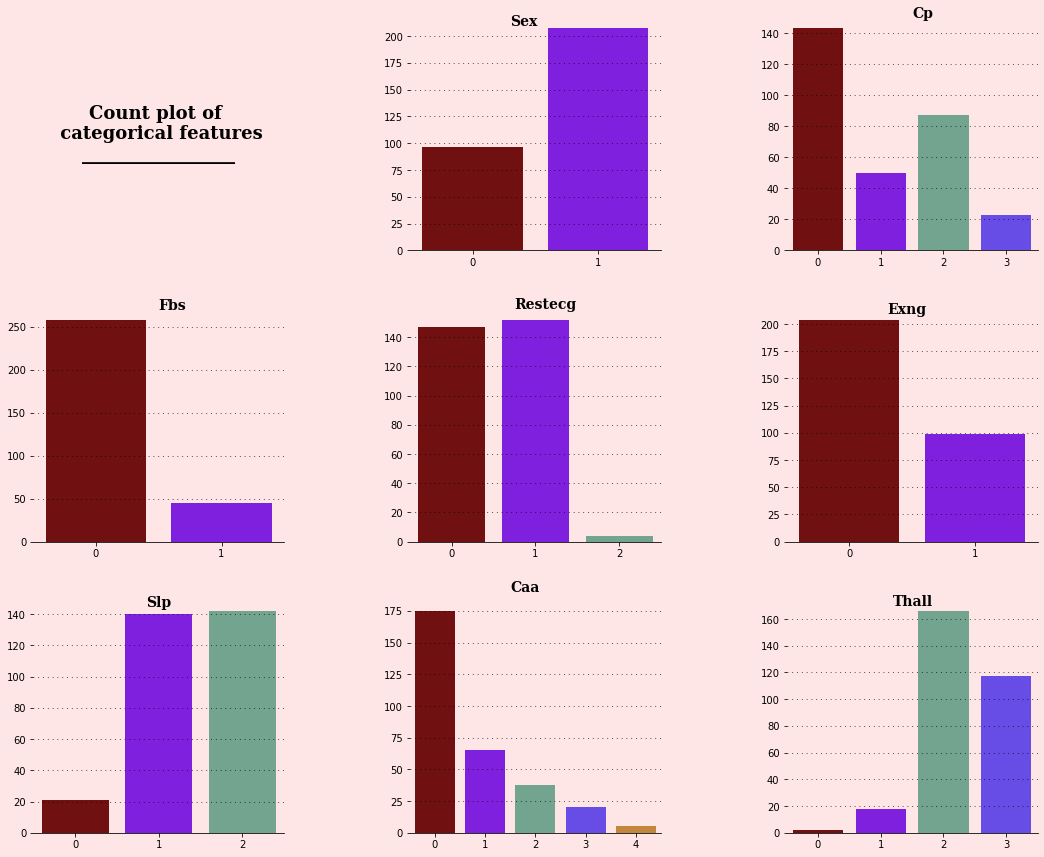

In [14]:
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])
ax6 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[2,1])
ax8 = fig.add_subplot(gs[2,2])

background_color = "#ffe6e6"
color_palette = ["#800000","#8000ff","#6aac90","#5833ff","#da8829"]
fig.patch.set_facecolor(background_color) 
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 
ax2.set_facecolor(background_color) 
ax3.set_facecolor(background_color) 
ax4.set_facecolor(background_color) 
ax5.set_facecolor(background_color) 
ax6.set_facecolor(background_color) 
ax7.set_facecolor(background_color) 
ax8.set_facecolor(background_color) 

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Count plot of \n categorical features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Sex count
ax1.text(0.3, 210, 'Sex', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax1,data=heart_df,x='sex',palette=color_palette)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Exng count
ax2.text(1.5, 150, 'Cp', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax2,data=heart_df,x='cp',palette=color_palette)
ax2.set_xlabel("")
ax2.set_ylabel("")

# Caa count
ax3.text(0.5, 270, 'Fbs', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax3,data=heart_df,x='fbs',palette=color_palette)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Cp count
ax4.text(0.75, 160, 'Restecg', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax4,data=heart_df,x='restecg',palette=color_palette)
ax4.set_xlabel("")
ax4.set_ylabel("")

# Fbs count
ax5.text(0.3, 210, 'Exng', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax5,data=heart_df,x='exng',palette=color_palette)
ax5.set_xlabel("")
ax5.set_ylabel("")

# Restecg count
ax6.text(0.85, 145, 'Slp', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax6.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax6,data=heart_df,x='slp',palette=color_palette)
ax6.set_xlabel("")
ax6.set_ylabel("")

# Slp count
ax7.text(1.5, 190, 'Caa', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax7,data=heart_df,x='caa',palette=color_palette)
ax7.set_xlabel("")
ax7.set_ylabel("")

# Thall count
ax8.text(1.2, 170, 'Thall', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax8.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax8,data=heart_df,x='thall',palette=color_palette)
ax8.set_xlabel("")
ax8.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)
    ax6.spines[s].set_visible(False)
    ax7.spines[s].set_visible(False)
    ax8.spines[s].set_visible(False)


### 수치형 피처의 boxenplot, distplot

[]

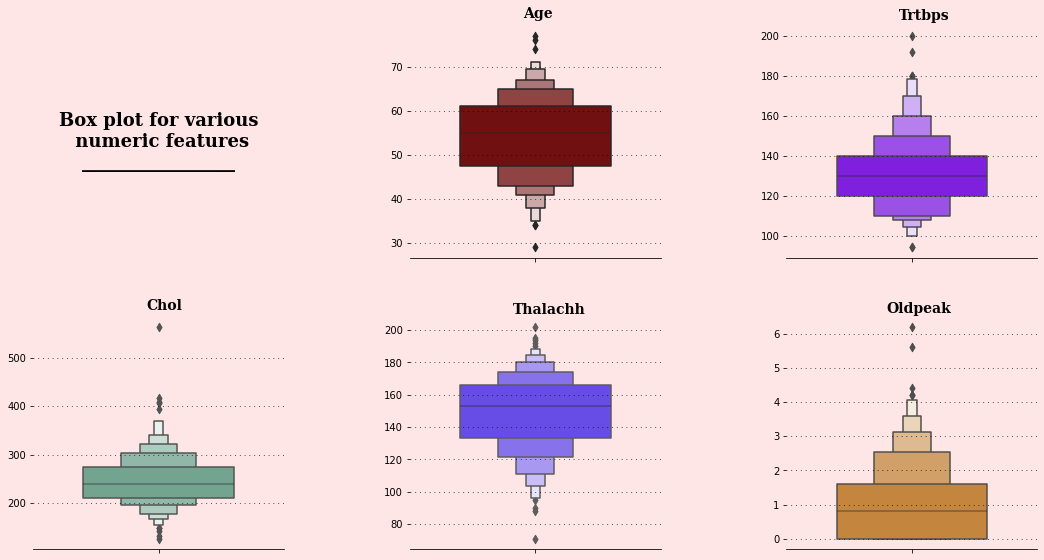

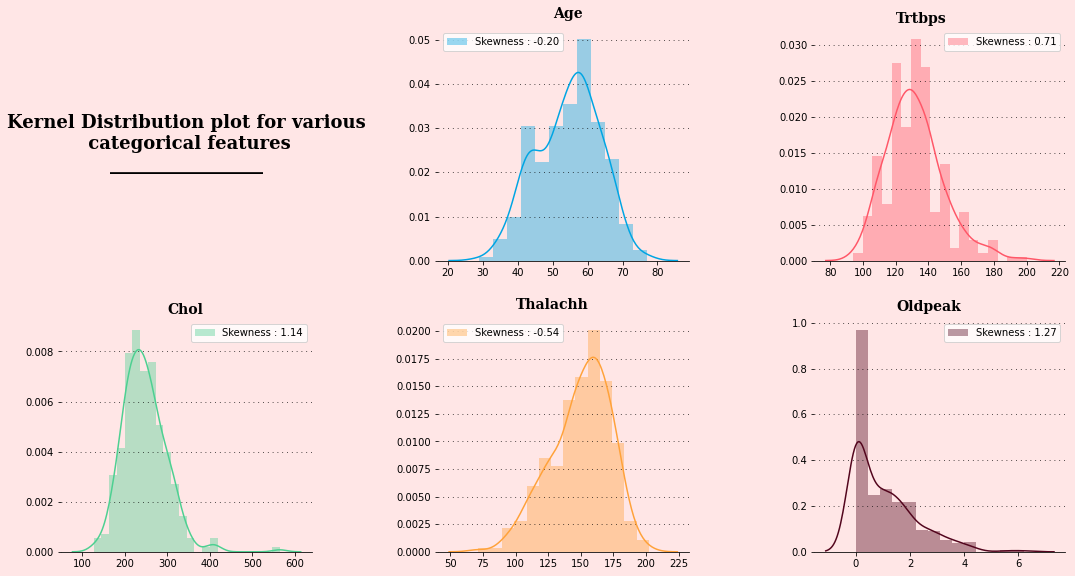

<Figure size 1080x720 with 0 Axes>

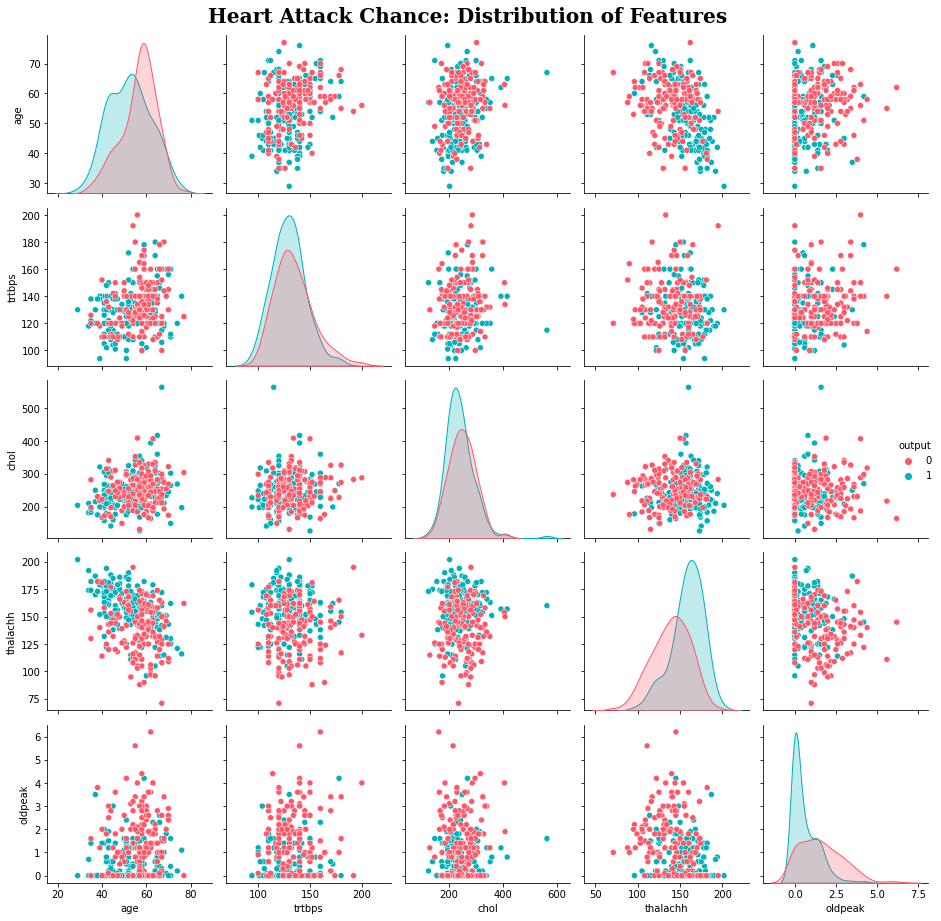

In [16]:
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])

background_color = "#ffe6e6"
color_palette = ["#800000","#8000ff","#6aac90","#5833ff","#da8829"]
fig.patch.set_facecolor(background_color) 
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 
ax2.set_facecolor(background_color) 
ax3.set_facecolor(background_color) 
ax4.set_facecolor(background_color) 
ax5.set_facecolor(background_color) 

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Box plot for various\n numeric features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Age 
ax1.text(-0.05, 81, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax1,y=heart_df['age'],palette=["#800000"],width=0.6)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Trtbps 
ax2.text(-0.05, 208, 'Trtbps', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax2,y=heart_df['trtbps'],palette=["#8000ff"],width=0.6)
ax2.set_xlabel("")
ax2.set_ylabel("")

# Chol 
ax3.text(-0.05, 600, 'Chol', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax3,y=heart_df['chol'],palette=["#6aac90"],width=0.6)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Thalachh 
ax4.text(-0.09, 210, 'Thalachh', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax4,y=heart_df['thalachh'],palette=["#5833ff"],width=0.6)
ax4.set_xlabel("")
ax4.set_ylabel("")

# oldpeak 
ax5.text(-0.1, 6.6, 'Oldpeak', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax5,y=heart_df['oldpeak'],palette=["#da8829"],width=0.6)
ax5.set_xlabel("")
ax5.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)

##### distplot #####
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])

background_color = "#ffe6e6"
color_palette = ["#800000","#8000ff","#6aac90","#5833ff","#da8829"]
fig.patch.set_facecolor(background_color) 
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 
ax2.set_facecolor(background_color) 
ax3.set_facecolor(background_color) 
ax4.set_facecolor(background_color) 
ax5.set_facecolor(background_color) 

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Kernel Distribution plot for various\n categorical features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Age 
ax1.text(50, 0.055, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.distplot(ax=ax1,x=heart_df['age'], color = '#00A5E3', label = 'Skewness : {:.2f}'.format(heart_df['age'].skew()))
ax1.legend(loc = 'best')
ax1.set_xlabel("")
ax1.set_ylabel("")

# Trtbps 
ax2.text(120, 0.033, 'Trtbps', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.distplot(ax=ax2,x=heart_df['trtbps'],color = '#FF5768', label = 'Skewness : {:.2f}'.format(heart_df['trtbps'].skew()))
ax2.legend(loc = 'best')
ax2.set_xlabel("")
ax2.set_ylabel("")

# Chol 
ax3.text(300, 0.0095, 'Chol', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.distplot(ax=ax3,x=heart_df['chol'], color = '#4DD091', label = 'Skewness : {:.2f}'.format(heart_df['chol'].skew()))
ax3.legend(loc = 'best')
ax3.set_xlabel("")
ax3.set_ylabel("")

# Thalachh 
ax4.text(100, 0.022, 'Thalachh', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.distplot(ax=ax4,x=heart_df['thalachh'], color = '#FFA23A', label = 'Skewness : {:.2f}'.format(heart_df['thalachh'].skew()))
ax4.legend(loc = 'best')
ax4.set_xlabel("")
ax4.set_ylabel("")

# oldpeak 
ax5.text(1.5, 1.05, 'Oldpeak', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.distplot(ax=ax5,x=heart_df['oldpeak'], color = '#53051D', label = 'Skewness : {:.2f}'.format(heart_df['oldpeak'].skew()))
ax5.legend(loc = 'best')
ax5.set_xlabel("")
ax5.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)

#### 연속형 변수 시각화
num_cols = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'output']

plt.figure(figsize=(15,10))
sns.pairplot(heart_df[num_cols], hue = "output", palette = ['#FF5768', '#00B0BA'])
plt.suptitle("Heart Attack Chance: Distribution of Features", y = 1.02, fontsize = 20, fontweight='bold', fontfamily='serif', color = "#000000")
# plt.legend("output")
plt.tight_layout()
plt.plot()


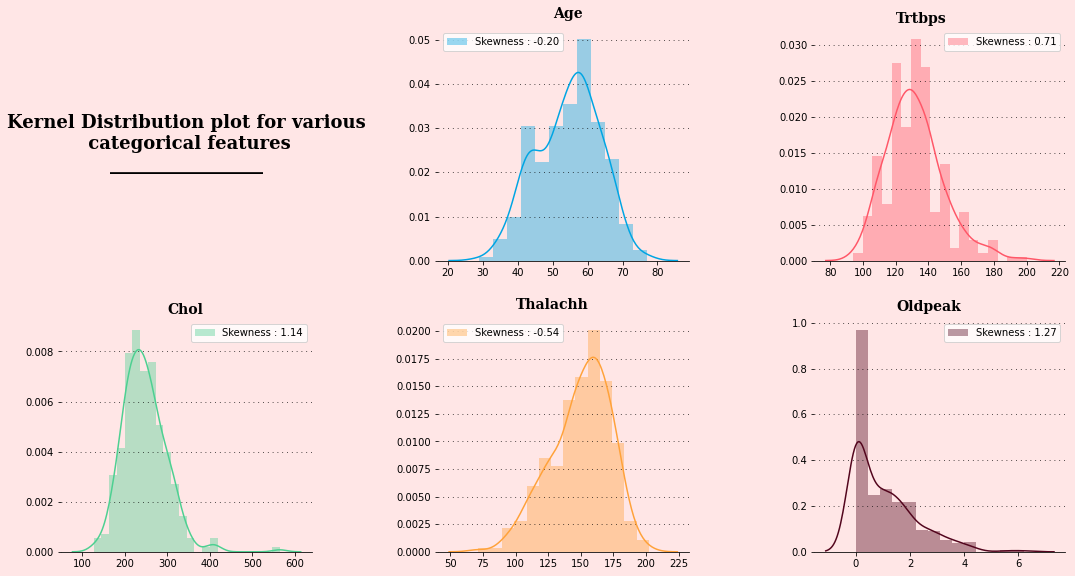

In [17]:
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])


background_color = "#ffe6e6"
color_palette = ["#800000","#8000ff","#6aac90","#5833ff","#da8829"]
fig.patch.set_facecolor(background_color) 
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 
ax2.set_facecolor(background_color) 
ax3.set_facecolor(background_color) 
ax4.set_facecolor(background_color) 
ax5.set_facecolor(background_color) 


# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Kernel Distribution plot for various\n categorical features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Age 
ax1.text(50, 0.055, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.distplot(ax=ax1,x=heart_df['age'], color = '#00A5E3', label = 'Skewness : {:.2f}'.format(heart_df['age'].skew()))
ax1.legend(loc = 'best')
ax1.set_xlabel("")
ax1.set_ylabel("")


# Trtbps 
ax2.text(120, 0.033, 'Trtbps', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.distplot(ax=ax2,x=heart_df['trtbps'],color = '#FF5768', label = 'Skewness : {:.2f}'.format(heart_df['trtbps'].skew()))
ax2.legend(loc = 'best')
ax2.set_xlabel("")
ax2.set_ylabel("")

# Chol 
ax3.text(300, 0.0095, 'Chol', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.distplot(ax=ax3,x=heart_df['chol'], color = '#4DD091', label = 'Skewness : {:.2f}'.format(heart_df['chol'].skew()))
ax3.legend(loc = 'best')
ax3.set_xlabel("")
ax3.set_ylabel("")

# Thalachh 
ax4.text(100, 0.022, 'Thalachh', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.distplot(ax=ax4,x=heart_df['thalachh'], color = '#FFA23A', label = 'Skewness : {:.2f}'.format(heart_df['thalachh'].skew()))
ax4.legend(loc = 'best')
ax4.set_xlabel("")
ax4.set_ylabel("")

# oldpeak 
ax5.text(1.5, 1.05, 'Oldpeak', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.distplot(ax=ax5,x=heart_df['oldpeak'], color = '#53051D', label = 'Skewness : {:.2f}'.format(heart_df['oldpeak'].skew()))
ax5.legend(loc = 'best')
ax5.set_xlabel("")
ax5.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)

[]

<Figure size 1080x720 with 0 Axes>

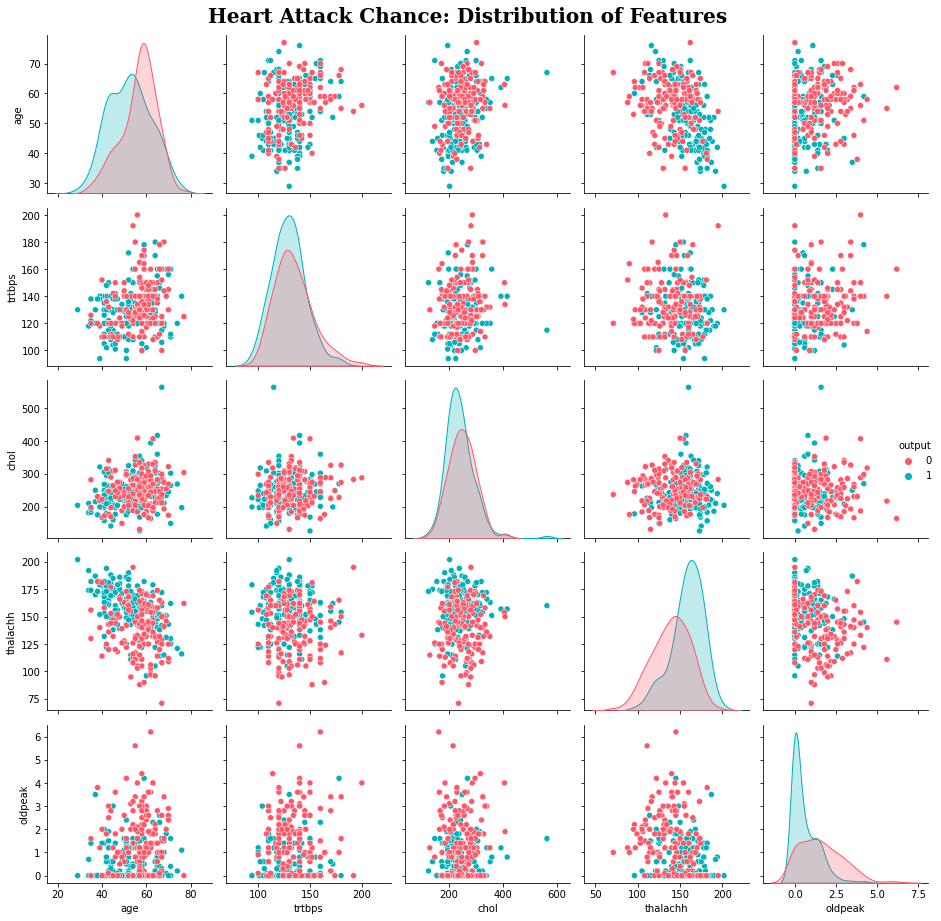

In [18]:
# 연속형 변수 scatterplot
num_cols = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak', 'output']

plt.figure(figsize=(15,10))
sns.pairplot(heart_df[num_cols], hue = "output", palette = ['#FF5768', '#00B0BA'])
plt.suptitle("Heart Attack Chance: Distribution of Features", y = 1.02, fontsize = 20, fontweight='bold', fontfamily='serif', color = "#000000")
# plt.legend("output")
plt.tight_layout()
plt.plot()

# 이변량 분석(output 기준)

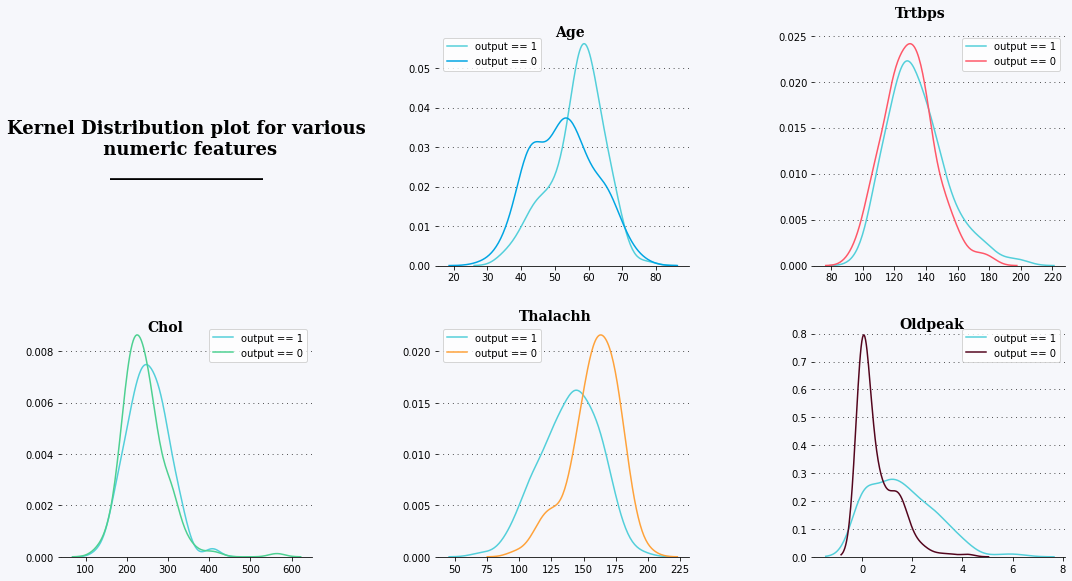

In [19]:
##### kdeplot #####
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])


background_color = "#F6F7FB"
color_palette = ["#00A5E3","#FF5768","#4DD091","#FFA23A","#53051D"]
fig.patch.set_facecolor(background_color) 
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 
ax2.set_facecolor(background_color) 
ax3.set_facecolor(background_color) 
ax4.set_facecolor(background_color) 
ax5.set_facecolor(background_color) 


# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Kernel Distribution plot for various\n numeric features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Age 
ax1.text(50, 0.058, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
# sns.distplot(ax=ax1,x=heart_df['age'], color = '#00A5E3', label = 'Skewness : {:.2f}'.format(heart_df['age'].skew()))
sns.kdeplot(heart_df[heart_df["output"] == 0]['age'], ax = ax1, color = '#53CFDA')
sns.kdeplot(heart_df[heart_df["output"] == 1]['age'], ax = ax1, color = '#00A5E3')
ax1.legend(["output == 1", "output == 0"]) # loc = 'upper right'
# ax1.legend(loc = 'best')
ax1.set_xlabel("")
ax1.set_ylabel("")


# Trtbps 
ax2.text(120, 0.027, 'Trtbps', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(heart_df[heart_df["output"] == 0]['trtbps'], ax = ax2, color = '#53CFDA')
sns.kdeplot(heart_df[heart_df["output"] == 1]['trtbps'], ax = ax2, color = '#FF5768')
ax2.legend(["output == 1", "output == 0"], loc = 'best')
ax2.set_xlabel("")
ax2.set_ylabel("")

# Chol 
ax3.text(250, 0.0088, 'Chol', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(heart_df[heart_df["output"] == 0]['chol'], ax = ax3, color = '#53CFDA')
sns.kdeplot(heart_df[heart_df["output"] == 1]['chol'], ax = ax3, color = '#4DD091')
ax3.legend(["output == 1", "output == 0"], loc = 'best')
ax3.set_xlabel("")
ax3.set_ylabel("")

# Thalachh 
ax4.text(100, 0.023, 'Thalachh', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(heart_df[heart_df["output"] == 0]['thalachh'], ax = ax4, color = '#53CFDA')
sns.kdeplot(heart_df[heart_df["output"] == 1]['thalachh'], ax = ax4, color = '#FFA23A')
ax4.legend(["output == 1", "output == 0"], loc = 'best')
ax4.set_xlabel("")
ax4.set_ylabel("")

# oldpeak 
ax5.text(1.5, 0.82, 'Oldpeak', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.kdeplot(heart_df[heart_df["output"] == 0]['oldpeak'], ax = ax5, color = '#53CFDA')
sns.kdeplot(heart_df[heart_df["output"] == 1]['oldpeak'], ax = ax5, color = '#53051D')
ax5.legend(["output == 1", "output == 0"], loc = 'best')
ax5.set_xlabel("")
ax5.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)

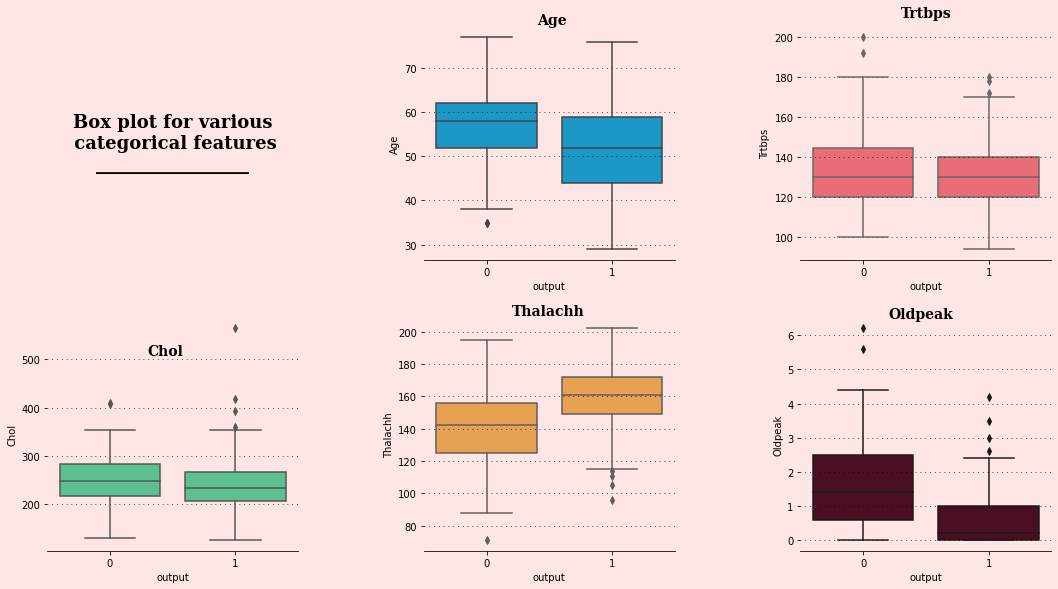

In [20]:
##### boxplot #####
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])


background_color = "#ffe6e6"
color_palette = ["#800000","#8000ff","#6aac90","#5833ff","#da8829"]
fig.patch.set_facecolor(background_color) 
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 
ax2.set_facecolor(background_color) 
ax3.set_facecolor(background_color) 
ax4.set_facecolor(background_color) 
ax5.set_facecolor(background_color) 


# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Box plot for various\n categorical features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Age 
ax1.text(0.4, 80, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(y = heart_df['age'], x = heart_df['output'], ax = ax1, color = '#00A5E3')
# ax1.legend(loc = 'best')
ax1.set_xlabel("output")
ax1.set_ylabel("Age")


# Trtbps 
ax2.text(0.3, 210, 'Trtbps', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(y = heart_df['trtbps'], x = heart_df['output'], ax = ax2, color = '#FF5768')
# ax2.legend(loc = 'best')
ax2.set_xlabel("output")
ax2.set_ylabel("Trtbps")

# Chol 
ax3.text(0.3, 510, 'Chol', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(y = heart_df['chol'], x = heart_df['output'], ax = ax3, color = '#4DD091')
# ax3.legend(loc = 'best')
ax3.set_xlabel("output")
ax3.set_ylabel("Chol")

# Thalachh 
ax4.text(0.2, 210, 'Thalachh', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(y = heart_df['thalachh'], x = heart_df['output'], ax = ax4, color = '#FFA23A')
# ax4.legend(loc = 'best')
ax4.set_xlabel("output")
ax4.set_ylabel("Thalachh")

# oldpeak 
ax5.text(0.2, 6.5, 'Oldpeak', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxplot(y = heart_df['oldpeak'], x = heart_df['output'], ax = ax5, color = '#53051D')
# ax5.legend(loc = 'best')
ax5.set_xlabel("output")
ax5.set_ylabel("Oldpeak")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)

### cp & output

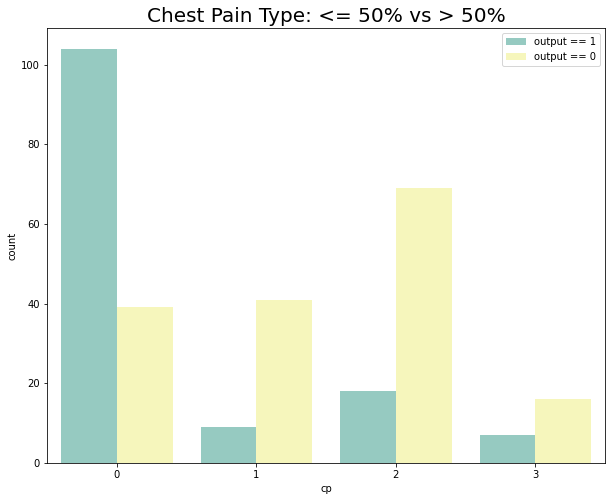

In [22]:
y_position = 1.02
plt.figure(figsize = (10, 8))
sns.countplot('cp', hue = 'output', data = heart_df, palette = sns.color_palette("Set3"))
plt.title("Chest Pain Type: <= 50% vs > 50%", fontsize = 20)
plt.legend(["output == 1", "output == 0"])
plt.show()

무증상인 환자는 심장 마비 가능성이 50%이상인 환자들보다 50%미만인 환자들이 더 많고, 2인 그 외의 환자들은 50% 미만인 환자들이 많다.

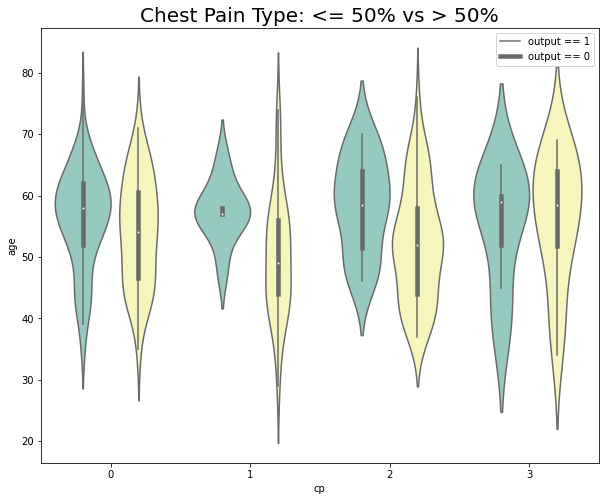

In [23]:
y_position = 1.02
plt.figure(figsize = (10, 8))
sns.violinplot('cp', 'age', hue = 'output', data = heart_df, palette = sns.color_palette("Set3"))
plt.title("Chest Pain Type: <= 50% vs > 50%", fontsize = 20)
plt.legend(["output == 1", "output == 0"])
plt.show()

# 결측치

In [24]:
heart_df[['caa', 'output']].groupby(['caa'], as_index = True).count()
heart_df[['thall', 'output']].groupby(['thall'], as_index = True).count()

heart_df.loc[heart_df['caa'] == 4, 'caa'] = 0
heart_df.loc[heart_df['thall'] == 0, 'thall'] = 2

# 연속형 변수 그룹화

In [30]:
# age 그룹화
heart_df['age_range'] = pd.qcut(heart_df['age'], 4)
heart_df.groupby(['age_range'])['output'].mean().to_frame().style.background_gradient(cmap = 'summer_r')


,output
age_range,
"(28.999, 47.5]",0.723684
"(47.5, 55.0]",0.631579
"(55.0, 61.0]",0.350000
"(61.0, 77.0]",0.478873


In [31]:
heart_df['age_cat'] = 0
heart_df.loc[heart_df['age'] <= 47, 'age_cat'] = 0
heart_df.loc[(heart_df['age'] > 47) & (heart_df['age'] <= 55), 'age_cat'] = 1
heart_df.loc[(heart_df['age'] > 55) & (heart_df['age'] <= 61), 'age_cat'] = 2
heart_df.loc[heart_df['age'] > 61, 'age_cat'] = 4

In [32]:
# trtbps 그룹화
heart_df['trtbps_range'] = pd.qcut(heart_df['trtbps'], 3)
heart_df.groupby(['trtbps_range'])['output'].mean().to_frame().style.background_gradient(cmap = 'summer_r')


,output
trtbps_range,
"(93.999, 122.667]",0.623762
"(122.667, 138.0]",0.552381
"(138.0, 200.0]",0.453608


In [33]:
heart_df['trtbps_cat'] = 0
heart_df.loc[heart_df['trtbps'] <= 122.667, 'trtbps_cat'] = 0
heart_df.loc[(heart_df['trtbps'] > 122.667) & (heart_df['trtbps'] <= 138), 'trtbps_cat'] = 1
heart_df.loc[heart_df['trtbps'] > 138, 'trtbps_cat'] = 2

In [34]:
# chol 그룹화
heart_df['chol_range'] = pd.qcut(heart_df['chol'], 3)
heart_df.groupby(['chol_range'])['output'].mean().to_frame().style.background_gradient(cmap = 'summer_r')


,output
chol_range,
"(125.999, 221.667]",0.623762
"(221.667, 263.0]",0.549020
"(263.0, 564.0]",0.460000


In [35]:
heart_df['chol_cat'] = 0
heart_df.loc[heart_df['chol'] <= 221.667, 'chol_cat'] = 0
heart_df.loc[(heart_df['chol'] > 221.667) & (heart_df['chol'] <= 263), 'chol_cat'] = 1
heart_df.loc[heart_df['chol'] > 263, 'chol_cat'] = 2

In [36]:
# thalachh 그룹화
heart_df['thalachh_range'] = pd.qcut(heart_df['thalachh'], 4)
heart_df.groupby(['thalachh_range'])['output'].mean().to_frame().style.background_gradient(cmap = 'summer_r')


,output
thalachh_range,
"(70.999, 133.5]",0.263158
"(133.5, 153.0]",0.474359
"(153.0, 166.0]",0.635135
"(166.0, 202.0]",0.813333


In [37]:
heart_df['thalachh_cat'] = 0
heart_df.loc[heart_df['thalachh'] <= 133.5, 'thalachh_cat'] = 0
heart_df.loc[(heart_df['thalachh'] > 133.5) & (heart_df['thalachh'] <= 153.0), 'thalachh_cat'] = 1
heart_df.loc[(heart_df['thalachh'] > 153.0) & (heart_df['thalachh'] <= 166.0), 'thalachh_cat'] = 2
heart_df.loc[heart_df['thalachh'] > 166.0, 'thalachh_cat'] = 3

In [38]:
# oldpeak 그룹화
heart_df['oldpeak_band'] = 0
heart_df.loc[heart_df['oldpeak'] <= 1, 'oldpeak_band'] = 0
heart_df.loc[(heart_df['oldpeak'] > 1) & (heart_df['oldpeak'] <= 2), 'oldpeak_band'] = 1
heart_df.loc[(heart_df['oldpeak'] > 2) & (heart_df['oldpeak'] <= 3), 'oldpeak_band'] = 2
heart_df.loc[(heart_df['oldpeak'] > 3) & (heart_df['oldpeak'] <= 4), 'oldpeak_band'] = 3
heart_df.loc[heart_df['oldpeak'] > 4, 'oldpeak_band'] = 4

In [39]:
heart_df['oldpeak_band'].value_counts().to_frame().style.background_gradient(cmap = 'summer_r')

,oldpeak_band
0,180
1,73
2,30
3,15
4,5


In [40]:
# 원래 변수 제거
heart_df.drop(['age', 'age_range', 'trtbps', 'trtbps_range', 'chol', 'chol_range', 'thalachh', 'thalachh_range', 'oldpeak'], axis = 1, inplace = True)


In [41]:
# 명목형 변수로 변환
cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'caa', 'thall']
num_cols = ['age_cat', 'trtbps_cat', 'chol_cat', 'thalachh_cat', 'oldpeak_band']

for col in cat_cols:
  heart_df[col] = heart_df[col].astype('str')

# 변수 인코딩

In [42]:
df_tree = heart_df.apply(LabelEncoder().fit_transform)
df_tree.head()

,sex,cp,fbs,restecg,exng,slp,caa,thall,output,age_cat,trtbps_cat,chol_cat,thalachh_cat,oldpeak_band
0,1,3,1,0,0,0,0,1,1,3,2,1,1,2
1,1,2,0,1,0,0,0,2,1,0,1,1,3,3
2,0,1,0,0,0,2,0,2,1,0,1,0,3,1
3,1,1,0,1,0,2,0,2,1,2,0,1,3,0
4,0,0,0,1,1,2,0,2,1,2,0,2,2,0


# 독립변수, 종속변수 나누기

In [43]:
X1 = df_tree.drop('output', axis = 1, inplace = False)
y1 = df_tree['output']

# 모델링

In [46]:
# 정확도, rocauc, f1_score
# LogisticRegression 모델
cv_accuracy = []
cv_rocauc = []
cv_f1 = []
kf = StratifiedKFold(n_splits = 5)

n_iter = 0

for fold, (train_index, valid_index) in enumerate(kf.split(X1, y1)):
  X_train, X_valid = X1.values[train_index], X1.values[valid_index]
  y_train, y_valid = y1[train_index], y1[valid_index]

  ro_scaler = MinMaxScaler()
  X_train = ro_scaler.fit_transform(X_train)
  X_valid = ro_scaler.transform(X_valid)

  clf = LogisticRegression()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_valid)
  print(f"The fold is : {fold} : ")
  print(classification_report(y_valid, y_pred))
  accuracy = accuracy_score(y_valid, y_pred)
  roc_auc = roc_auc_score(y_valid, y_pred)
  f1 = f1_score(y_valid, y_pred)

  train_size = X_train.shape[0]
  valid_size = X_valid.shape[0]
  print('\n#{0} 교차 검증 정확도: {1}, 교차 검증 roc: {2}, 교차 검증 f1: {3}, 학습 데이터 크기: {4}, 검증 데이터 크기: {5}'
         .format(n_iter, accuracy, roc_auc, f1, train_size, valid_size))
  print('#{0} 검증 세트 인덱스: {1}'.format(n_iter, valid_index))
  cv_accuracy.append(accuracy)
  cv_rocauc.append(roc_auc)
  cv_f1.append(f1)
  # print(f"The accuracy for Fold {fold+1} :  {acc}")

print('평균 검증정확도: ', np.mean(cv_accuracy))
print('평균 검증rocauc: ', np.mean(cv_rocauc))
print('평균 검증f1: ', np.mean(cv_f1))

The fold is : 0 : 
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        28
           1       0.78      0.88      0.83        33

    accuracy                           0.80        61
   macro avg       0.81      0.80      0.80        61
weighted avg       0.81      0.80      0.80        61


#0 교차 검증 정확도: 0.8032786885245902, 교차 검증 roc: 0.7965367965367965, 교차 검증 f1: 0.8285714285714285, 학습 데이터 크기: 242, 검증 데이터 크기: 61
#0 검증 세트 인덱스: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192]
The fold is : 1 : 
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        28
           1       0.88      0.88      0.88        33

    accuracy                           0.87        61
   macro avg       0.87     

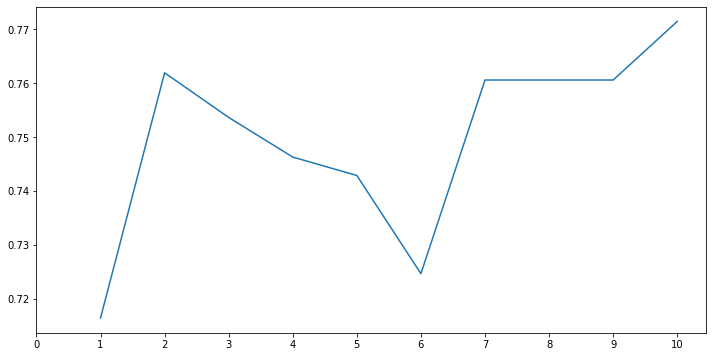

f1 scores for different values of n are:  [0.71641791 0.76190476 0.75362319 0.74626866 0.74285714 0.72463768
 0.76056338 0.76056338 0.76056338 0.77142857] with the max value as  0.7714285714285715


In [48]:
a_index = list(range(1, 11)) # 1-10
a = pd.Series()
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for i in list(range(1, 11)):
  model = KNeighborsClassifier(n_neighbors = i)
  model.fit(X_train, y_train)
  prediction = model.predict(X_valid)
  a = a.append(pd.Series(metrics.f1_score(prediction, y_valid)))
plt.plot(a_index, a)
plt.xticks(x)
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.show()
print('f1 scores for different values of n are: ', a.values, 'with the max value as ', a.values.max())


In [49]:
# voting
ensemble_lin_rbf = VotingClassifier(estimators = [('KNN', KNeighborsClassifier(n_neighbors = 7)),
                                                  ('RBF', svm.SVC(kernel = 'rbf', probability = True)),
                                                  ('RFor', RandomForestClassifier(n_estimators = 600, random_state = 0)),
                                                  ('LR', LogisticRegression(C = 0.1, penalty = "l2")),
                                                  ('DT', DecisionTreeClassifier(random_state = 0)),
                                                  ('NB', GaussianNB()),
                                                  ('svm', svm.SVC(kernel = 'linear', C = 0.3, gamma = 0.1, probability = True))],
                                    voting = 'soft').fit(X_train, y_train)
print('The accuracy for ensembled model is: ', ensemble_lin_rbf.score(X_valid, y_valid)) # 정확도
cross1 = cross_val_score(ensemble_lin_rbf, X1, y1, cv = 10, scoring = 'f1')
cross2 = cross_val_score(ensemble_lin_rbf, X1, y1, cv = 10, scoring = "roc_auc")
print('The cross validated f1_score is ', cross1.mean())
print("The cross validated roc_auc_score is ", cross2.mean())

The accuracy for ensembled model is:  0.75
The cross validated f1_score is  0.8622189260898938
The cross validated roc_auc_score is  0.9041289592760181


In [50]:
# bagging
bag = BaggingClassifier(base_estimator = LogisticRegression(C = 0.1, penalty = "l2"), random_state = 0, n_estimators = 200)
bag.fit(X_train, y_train)
prediction = bag.predict(X_valid)
print('The accuracy for bagged KNN is: ', metrics.f1_score(prediction, y_valid))
result = cross_val_score(bag, X1, y1, cv = 10, scoring = 'f1') # scoring = "roc_auc"
print('The cross validated score for bagged KNN is: ', result.mean()) # result.best_score_


The accuracy for bagged KNN is:  0.7837837837837839
The cross validated score for bagged KNN is:  0.8589879043129818


In [51]:
# adaboost
ada = AdaBoostClassifier(n_estimators = 300, random_state = 0, learning_rate = 0.01)
result1 = cross_val_score(ada, X1, y1, cv = 10, scoring = 'f1')
result2 = cross_val_score(ada, X1, y1, cv = 10, scoring = 'roc_auc')
print(result1.mean(), result2.mean())

0.8649453426132192 0.9210750646412411


In [70]:
# gradientboosting
grad = GradientBoostingClassifier(n_estimators = 300, random_state = 0, learning_rate = 0.05)
result1 = cross_val_score(grad, X1, y1, cv = 10, scoring = 'f1')
result2 = cross_val_score(grad, X1, y1, cv = 10, scoring = 'roc_auc')
print(result1.mean(), result2.mean())

0.826382717706247 0.882340820943762


In [52]:
# xgb
xgboost = xg.XGBClassifier(n_estimators = 700, learning_rate = 0.05)
result1 = cross_val_score(xgboost, X1, y1, cv = 10, scoring = 'f1')
result2 = cross_val_score(xgboost, X1, y1, cv = 10, scoring = 'roc_auc')
print(result1.mean(), result2.mean())

0.8257857344005352 0.8823044602456367


In [53]:
# 로지스틱
logis = LogisticRegression(C=0.1, penalty = "l2")
result1 = cross_val_score(logis, X1, y1, cv = 10, scoring = 'f1')
result2 = cross_val_score(logis, X1, y1, cv = 10, scoring = 'roc_auc')
print(result1.mean(), result2.mean())

0.8569964391636218 0.8987132352941176


In [54]:
# linear-SVC
linear_svc = svm.SVC(C=0.3, gamma=0.1, kernel='linear', random_state = 0)
result1 = cross_val_score(linear_svc, X1, y1, cv = 10, scoring = 'f1')
result2 = cross_val_score(linear_svc, X1, y1, cv = 10, scoring = 'roc_auc')
print(result1.mean(), result2.mean())

0.8438610497434027 0.8986021331609567


In [55]:
# linear-rbf
rbf_svc = svm.SVC(kernel='rbf', random_state = 0)
result1 = cross_val_score(rbf_svc, X1, y1, cv = 10, scoring = 'f1')
result2 = cross_val_score(rbf_svc, X1, y1, cv = 10, scoring = 'roc_auc')
print(result1.mean(), result2.mean())

0.8517045155754834 0.9075711053652231


In [56]:
# randomforest
random = RandomForestClassifier(n_estimators=600, random_state = 0)
result1 = cross_val_score(random, X1, y1, cv = 10, scoring = 'f1')
result2 = cross_val_score(random, X1, y1, cv = 10, scoring = 'roc_auc')
print(result1.mean(), result2.mean())


0.8547871257430082 0.9109637605042016


In [57]:
# kneighbors
random = KNeighborsClassifier(n_neighbors = 7)
result1 = cross_val_score(random, X1, y1, cv = 10, scoring = 'f1')
result2 = cross_val_score(random, X1, y1, cv = 10, scoring = 'roc_auc')
print(result1.mean(), result2.mean())

0.8342526257780177 0.8581639867485455


In [58]:
# gaussian
ga = GaussianNB()
result1 = cross_val_score(ga, X1, y1, cv = 10, scoring = 'f1')
result2 = cross_val_score(ga, X1, y1, cv = 10, scoring = 'roc_auc')
print(result1.mean(), result2.mean())

0.8231330815154344 0.8910047672915319


# 하이퍼파라미터 최적화

In [59]:
# decisiontree
hyper = {'max_depth':range(100, 1000, 100), 'min_samples_split':[1, 2,3, 4, 5]}
gd = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = hyper, verbose = True) # scoring="accuracy"
gd.fit(X1, y1)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
0.8148087431693989
DecisionTreeClassifier(max_depth=400, min_samples_split=5)


In [60]:
dt = DecisionTreeClassifier(max_depth=400, min_samples_split=4)
result1 = cross_val_score(dt, X1, y1, cv = 10, scoring = 'f1')
result2 = cross_val_score(dt, X1, y1, cv = 10, scoring = 'roc_auc')
print(result1.mean(), result2.mean())

0.8226778780410268 0.8172753716871363


In [61]:
result1 = cross_val_score(bag, X1, y1, cv = 10, scoring = 'f1')
result2 = cross_val_score(bag, X1, y1, cv = 10, scoring = 'roc_auc')
print(result1.mean(), result2.mean())

0.8589879043129818 0.8986809146735617


In [62]:
# SVM
C = [0.05, 0.1, 0.2, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
gamma = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
kernel = ['rbf', 'linear']
hyper = {'kernel': kernel, 'C': C, 'gamma': gamma}
gd = GridSearchCV(estimator = svm.SVC(), param_grid = hyper, verbose = True, cv = 5, n_jobs = -1)
gd.fit(X1, y1)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
0.8379781420765028
SVC(C=0.05, gamma=0.1, kernel='linear')


In [63]:
# Logistic
C = [0.05, 0.1, 0.2, 0.3, 0.35, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
penalty = ['l1', 'l2']
hyper = {'penalty': penalty, 'C': C}
gd = GridSearchCV(estimator = LogisticRegression(), param_grid = hyper, verbose = True, cv = 5, n_jobs = -1)
gd.fit(X_train, y_train)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.8519557823129252
LogisticRegression()


In [64]:
# Random Forests
n_estimators = range(100, 1000, 100)
hyper = {'n_estimators': n_estimators}
gd = GridSearchCV(estimator = RandomForestClassifier(random_state = 0), param_grid = hyper, verbose = True) # scoring="accuracy"
gd.fit(X1, y1)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.8314207650273223
RandomForestClassifier(n_estimators=200, random_state=0)


In [65]:
# bagging
n_estimators = range(100, 1000, 100)
hyper = {'n_estimators': n_estimators}
gd = GridSearchCV(estimator = BaggingClassifier(random_state = 0), param_grid = hyper, verbose = True) # scoring="accuracy"
gd.fit(X1, y1)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.8179781420765029
BaggingClassifier(n_estimators=300, random_state=0)


In [66]:
# ada
learning_rate = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
n_estimators = range(100, 1000, 100)
hyper = {'learning_rate': learning_rate, "n_estimators": n_estimators}
gd = GridSearchCV(estimator = AdaBoostClassifier(random_state = 0), param_grid = hyper, verbose = True) # scoring="accuracy"
gd.fit(X1, y1)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
0.8579781420765027
AdaBoostClassifier(learning_rate=0.01, n_estimators=300, random_state=0)


In [67]:
# gradient
learning_rate = [0.0001, 0.001, 0.01, 0.05, 0.1]
n_estimators = range(100, 1000, 100)
hyper = {'learning_rate': learning_rate, "n_estimators": n_estimators}
gd = GridSearchCV(estimator = GradientBoostingClassifier(random_state = 0), param_grid = hyper, verbose = True) # scoring="accuracy"
gd.fit(X1, y1)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
0.8414207650273224
GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, random_state=0)


In [68]:
# xg
hyper = {'learning_rate': [0.01,0.05,0.1,0.15], 
         "n_estimators": range(100, 1000, 100)}
gd = GridSearchCV(estimator = xg.XGBClassifier(random_state = 0), param_grid = hyper, verbose = True) # scoring="accuracy"
gd.fit(X1, y1)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.8414754098360657
XGBClassifier(n_estimators=300)


#### 최적화 수행후 kfold

In [71]:
kfold = KFold(n_splits = 10, random_state = 22, shuffle = True) # k = 10, 데이터를 10부분으로 분리
xyz = []
f1_score = []
std = []
classfiers = ['Linear Svm', 'Radial Svm', 'Logistic Regression', 'KNN', 'Decision Tree', 'Naive Bayes', 'Random Forest',
              'Voting', 'Bagging', 'AdaBoost', 'Gradient', 'xgb']
models = [svm.SVC(C=0.3, gamma=0.1, kernel='linear'), svm.SVC(kernel = 'rbf'), LogisticRegression(C=0.1, penalty = "l2"), 
          KNeighborsClassifier(n_neighbors = 7),
          DecisionTreeClassifier(), GaussianNB(), RandomForestClassifier(n_estimators=600),
          ensemble_lin_rbf, bag, ada, grad, xgboost]
for i in models:
  model = i
  cv_result = cross_val_score(model, X1, y1, cv = kfold, scoring = 'f1')
  cv_result = cv_result
  xyz.append(cv_result.mean())
  std.append(cv_result.std())
  f1_score.append(cv_result)

new_models_dataframe2 = pd.DataFrame({'CV Mean': xyz, 'Std': std}, index = classfiers)
new_models_dataframe2

,CV Mean,Std
Linear Svm,0.848150,0.079300
Radial Svm,0.863454,0.074211
Logistic Regression,0.854636,0.070790
KNN,0.820218,0.071890
Decision Tree,0.802726,0.074960
Naive Bayes,0.830738,0.059512
Random Forest,0.842966,0.058788
Voting,0.855567,0.062718
Bagging,0.852328,0.068871
AdaBoost,0.850817,0.075963


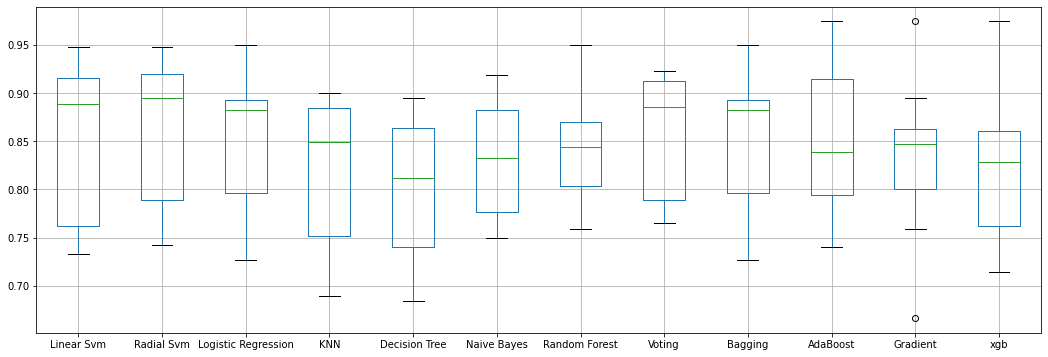

In [73]:
# 모델 boxplot
plt.subplots(figsize = (18, 6))
box = pd.DataFrame(f1_score, index = classfiers)
box.T.boxplot()

# 혼동행렬

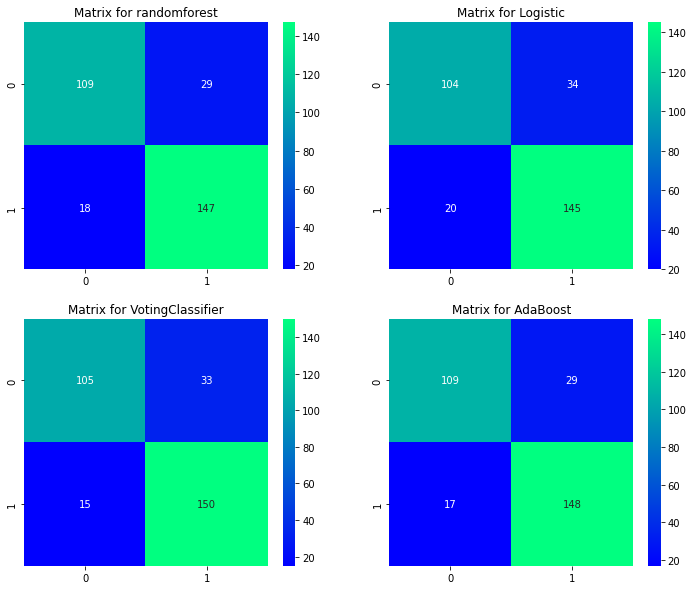

In [74]:
# 혼동행렬
f, ax = plt.subplots(2, 2, figsize = (12, 10))

y_pred1 = cross_val_predict(RandomForestClassifier(n_estimators=600), X1, y1, cv=10)
sns.heatmap(confusion_matrix(y1, y_pred1), ax = ax[0, 0], annot = True, fmt='2.0f', cmap = 'winter')
ax[0, 0].set_title('Matrix for randomforest')
y_pred2 = cross_val_predict(LogisticRegression(C=0.7, penalty = "l2"), X1, y1, cv=10)
sns.heatmap(confusion_matrix(y1, y_pred2), ax = ax[0, 1], annot = True, fmt='2.0f', cmap = 'winter')
ax[0, 1].set_title('Matrix for Logistic')
y_pred3 = cross_val_predict(ensemble_lin_rbf, X1, y1, cv=10)
sns.heatmap(confusion_matrix(y1, y_pred3), ax = ax[1, 0], annot = True, fmt='2.0f', cmap = 'winter')
ax[1, 0].set_title('Matrix for VotingClassifier')
y_pred4 = cross_val_predict(AdaBoostClassifier(n_estimators = 300, random_state = 0, learning_rate = 0.01), X1, y1, cv=10)
sns.heatmap(confusion_matrix(y1, y_pred4), ax = ax[1, 1], annot = True, fmt='2.0f', cmap = 'winter')
ax[1, 1].set_title('Matrix for AdaBoost')

plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

# 평가지표

In [75]:
print("random\n", classification_report(y1, y_pred1))
print("logistic\n", classification_report(y1, y_pred2))
print("voting\n", classification_report(y1, y_pred3))
print("ada\n", classification_report(y1, y_pred4))

random
               precision    recall  f1-score   support

           0       0.86      0.79      0.82       138
           1       0.84      0.89      0.86       165

    accuracy                           0.84       303
   macro avg       0.85      0.84      0.84       303
weighted avg       0.85      0.84      0.84       303

logistic
               precision    recall  f1-score   support

           0       0.84      0.75      0.79       138
           1       0.81      0.88      0.84       165

    accuracy                           0.82       303
   macro avg       0.82      0.82      0.82       303
weighted avg       0.82      0.82      0.82       303

voting
               precision    recall  f1-score   support

           0       0.88      0.76      0.81       138
           1       0.82      0.91      0.86       165

    accuracy                           0.84       303
   macro avg       0.85      0.83      0.84       303
weighted avg       0.84      0.84      0.84     

# 회귀계수와 변수 중요도 시각화

In [77]:
from sklearn.feature_extraction.text import CountVectorizer

In [78]:
vectorizer = CountVectorizer(max_features = 1000)
vect = vectorizer.fit_transform(X1.columns)

In [81]:
random = LogisticRegression(C=0.7, penalty = "l2")
random.fit(X1, y1)

vectorizer = CountVectorizer(max_features = 1000)
vect = vectorizer.fit_transform(X1.columns)

keywords = pd.DataFrame(random.coef_, columns = list(vectorizer.vocabulary_.keys()))
df1 = keywords.T.sort_values(by = 0, ascending = False)
df1

,0
cp,0.802386
slp,0.570251
thalachh_cat,0.369473
restecg,0.314685
fbs,-0.004155
age_cat,-0.138231
trtbps_cat,-0.263747
chol_cat,-0.322782
oldpeak_band,-0.574936
caa,-0.722794


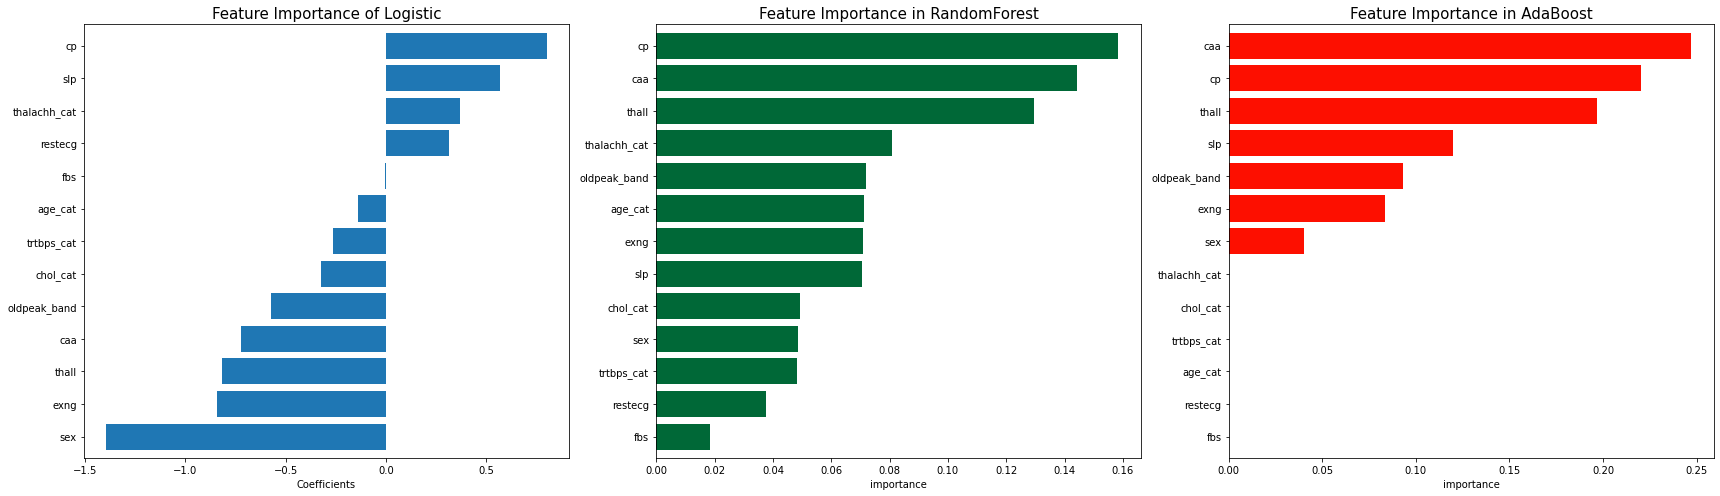

In [82]:
f, ax = plt.subplots(figsize = (24, 7), nrows = 1, ncols = 3)
pd.Series(df1[0].values, df1.index).sort_values(ascending = True).plot.barh(width = 0.8, ax = ax[0])
ax[0].set_title('Feature Importance of Logistic', fontsize = 15)
ax[0].set_xlabel("Coefficients")

model = RandomForestClassifier(n_estimators = 600, random_state = 0)
model.fit(X1, y1)
pd.Series(model.feature_importances_, X1.columns).sort_values(ascending = True).plot.barh(width = 0.8, ax = ax[1], cmap = 'RdYlGn_r')
ax[1].set_title('Feature Importance in RandomForest', fontsize = 15)
ax[1].set_xlabel("importance")

model = AdaBoostClassifier(n_estimators = 300, random_state = 0, learning_rate = 0.01)
model.fit(X1, y1)
pd.Series(model.feature_importances_, X1.columns).sort_values(ascending = True).plot.barh(width = 0.8, ax = ax[2], color = '#FD0F00')
ax[2].set_title('Feature Importance in AdaBoost', fontsize = 15)
ax[2].set_xlabel("importance")

plt.tight_layout()
plt.show()

프로젝트에서 코드 돌린 분류 지표 결과와 깃헙에 올린 결과가 조금 다르다...왜지?